In [16]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum
from gammapy.data import DataStore
from gammapy.maps import Map
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.spectrum import SpectrumObservationList, SpectrumExtraction

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

from regions import CircleSkyRegion

%matplotlib inline

In [17]:
# print(theano.config)
class Integrate(theano.Op):
    def __init__(self, expr, var, lower, upper, *inputs):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = inputs
        self.lower = lower
        self.upper = upper
        self._func = theano.function(
            [var] + list(self._extra_vars),
            self._expr,
            on_unused_input='ignore'
        )
    
    def make_node(self, *inputs):
        assert len(self._extra_vars)  == len(inputs)
        return theano.Apply(self, list(inputs), [T.dscalar().type()])
    
    def perform(self, node, inputs, out):
        x = np.linspace(self.lower, self.upper, num=3)
        y = np.array([self._func(i , *inputs) for i in x])
        val = trapz(y, x)
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        out, = grads
        grads = T.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, self.lower, self.upper, *self._extra_vars)
            darg = out * integrate(*inputs)
            dargs.append(darg)
            
        return dargs

In [18]:
def forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observations, fit_range=None):
    
    amplitude *= 1e-11
    obs_bins = observations[0].on_vector.energy.bins.to_value(u.TeV)
    predicted_signal_per_observation = []
    for observation in observations:
        aeff_bins = observation.aeff.energy
        e_reco_bins = observation.edisp.e_reco
        e_true_bins = observation.edisp.e_true

        lower =  e_true_bins.lo.to_value(u.TeV)
        upper = e_true_bins.hi.to_value(u.TeV)

        energy = T.dscalar('energy')
        amplitude_ = T.dscalar('amplitude_')
        alpha_ = T.dscalar('alpha_')
        beta_ = T.dscalar('beta_')

        func = amplitude_ * energy **(-alpha_ - beta_ * T.log10(energy))

        counts = []
        for a, b in zip(lower, upper):
            c = Integrate(func, energy, a, b, amplitude_, alpha_, beta_)(amplitude, alpha, beta)
            counts.append(c)

        counts = T.stack(counts)
        aeff = observation.aeff.data.data.to_value(u.cm**2).astype(np.float32)
        aeff = aeff


        counts *= aeff
        counts *= observation.livetime.to_value(u.s)
        edisp = observation.edisp.pdf_matrix
        edisp = edisp

        predicted_signal_per_observation.append(T.dot(counts, edisp))

    predicted_counts = T.sum(predicted_signal_per_observation, axis=0)
    if fit_range is not None:
        energy_bins = observations[0].on_vector.energy.bins
        idx = np.searchsorted(energy_bins.to_value(u.TeV), fit_range.to_value(u.TeV))
        predicted_counts = predicted_counts[idx[0]:idx[1]]

    return predicted_counts


In [19]:
def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]

In [45]:
def load_data(telescope='fact', reco_bins=18, true_bins=25):
    
    crab_position = SkyCoord(ra='83d37m59.0988s', dec='22d00m52.2s')
    exclusion_map = Map.read(f"./data/exclusion_mask.fits.gz")

    energy_range = {
        'fact': [0.55, 17] * u.TeV,
        'magic': [0.04, 18] * u.TeV,
        'veritas': [0.11, 20] * u.TeV,
        'hess': [0.6, 20] * u.TeV,
    }

    on_radius = {
        'fact': 0.17 * u.deg,
        'magic': 0.142 * u.deg,
        'veritas': 0.10 * u.deg,
        'hess': 0.11 * u.deg,
    }

    ds = DataStore.from_dir(f'./data/{telescope}/')
    observations = ds.obs_list(ds.hdu_table['OBS_ID'].data)

    fit_range = energy_range[telescope]

    e_true_bins = np.logspace(*np.log10(fit_range.value), true_bins + 1) * u.TeV
    e_reco_bins = np.logspace(*np.log10(fit_range.value), reco_bins + 1) * u.TeV

    on_region = CircleSkyRegion(center=crab_position, radius=on_radius[telescope])

    print('Estimating Background')
    bkg_estimate = ReflectedRegionsBackgroundEstimator(
        obs_list=observations, on_region=on_region, exclusion_mask=exclusion_map
    )
    bkg_estimate.run()

    print('Extracting Count Spectra')
    extract = SpectrumExtraction(
        obs_list=observations,
        bkg_estimate=bkg_estimate.result,
        e_true=e_true_bins,
        e_reco=e_reco_bins,
        containment_correction=False,
        use_recommended_erange=False,
    )

    extract.run()

    observations = extract.observations
    if telescope ==  'fact':
        return [observations.stack()], fit_range
    return observations, fit_range

In [54]:
observations, fit_range = load_data('magic')
obs_alpha = observations[0].alpha
energy_bins = observations[0].on_vector.energy.bins

Estimating Background
Extracting Count Spectra


In [55]:
def calc_mu_b(mu_s, on_data, off_data, exposure_ratio):
    alpha = exposure_ratio
    c = alpha * (on_data + off_data) - (alpha + 1)*mu_s
    d = pm.math.sqrt(c**2 + 4 * (alpha + 1)*alpha*off_data*mu_s)
    mu_b = (c + d) / (2*alpha*(alpha + 1))
    return mu_b

In [56]:
def get_observed_counts(observations, fit_range=None):
    on_data = []
    off_data = []
    
    for observation in observations:
        on_data.append(observation.on_vector.data.data.value)
        off_data.append(observation.off_vector.data.data.value)
    on_data = np.sum(on_data, axis=0)
    off_data = np.sum(off_data, axis=0)
    if fit_range is not None:
        energy_bins = observations[0].on_vector.energy.bins
        on_data, off_data = apply_range(on_data, off_data, fit_range=fit_range, bins=energy_bins)
    
    return on_data, off_data

In [57]:
on_data, off_data = get_observed_counts(observations, fit_range=fit_range)
# on_data, off_data = apply_range(on_data, off_data, fit_range=fit_range, bins=energy_bins)

exposure_ratio = observations[0].alpha
print(on_data.shape, off_data.shape, exposure_ratio )
livetime = observations[0].livetime.to_value(u.s)

# edisp = observation.edisp.pdf_matrix

model = pm.Model(theano_config={'compute_test_value': 'ignore'})
with model:

    amplitude = pm.TruncatedNormal('amplitude', mu=4, sd=0.5, lower=0.01, testval=4)
    alpha = pm.TruncatedNormal('alpha', mu=2.5, sd=0.5, lower=0.01, testval=2.5)
    beta = pm.TruncatedNormal('beta', mu=0.5, sd=0.5, lower=0.01, testval=0.5)
    
    mu_s = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observations, fit_range=fit_range)
#     pm.Potential('ll', wstat_model_symbolic(mu_s, observation, fit_range=fit_range))
#     mu_b = pm.HalfFlat('mu_b', shape=len(off_data))
#     mu_b = pm.TruncatedNormal('mu_b', mu=off_data, sd=5, shape=len(off_data), lower=0)
    mu_b  = pm.Deterministic('mu_b', calc_mu_b(mu_s, on_data, off_data, exposure_ratio), )
    b = pm.Poisson('background', mu=mu_b, observed=off_data, shape=len(off_data))    
    s = pm.Poisson('signal', mu=mu_s + exposure_ratio * mu_b, observed=on_data)

(18,) (18,) 0.14285714285714285


In [58]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

amplitude_lowerbound__ 1.1579998782570455
alpha_lowerbound__ 0.6864916757531656
beta_lowerbound__ -0.7605610100048488
background -49.87317416883226
signal -153.54962356309247


625it [00:16, 37.65it/s]


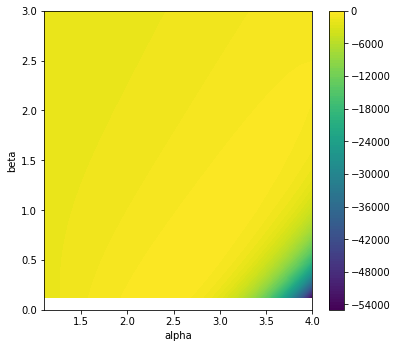

In [59]:
N = 25
betas = np.linspace(0, 3, N)
alphas = np.linspace(1.1, 4.0, N)
f = model.logp
zs = []
a, b = np.meshgrid(alphas, betas)
for al, be in tqdm(zip(a.ravel(), b.ravel())):
        
    p = f(amplitude_lowerbound__ = np.log(4), alpha_lowerbound__ = np.log(al), beta_lowerbound__= np.log(be))
#     print(p)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=124)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

In [60]:
with model:
    trace = pm.sample(600, cores=6, tune=600, init='auto') # advi+adapt_diag

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



You can find the C code in this temporary file: /var/folders/zb/pkkz3dr10s79pjsbslcf00mw0000gn/T/theano_compilation_error_8qz4er5p


Exception: ('The following error happened while compiling the node', Elemwise{Composite{(Switch(i0, (i1 * (i2 + i3) * i3), i4) + i5 + (((i6 * i7) + (i8 * i9) + (i10 * i11) + (i12 * i13) + (i14 * i15) + (i16 * i17) + (i18 * i19) + (i20 * i21) + (i22 * i23) + (i24 * i25) + (i26 * i27) + (i28 * i29) + (i30 * i31) + (i32 * i33) + (i34 * i35) + (i36 * i37) + (i38 * i39) + (i40 * i41) + (i42 * i43) + (i44 * i45) + (i46 * i47) + (i48 * i49) + (i50 * i51) + (i52 * i53) + (i54 * i55) + (i56 * i57) + (i58 * i59) + (i60 * i61) + (i62 * i63) + (i64 * i65) + (i66 * i67) + (i68 * i69) + (i70 * i71) + (i72 * i73) + (i74 * i75) + (i76 * i77) + (i78 * i79) + (i80 * i81) + (i82 * i83) + (i84 * i85) + (i86 * i87) + (i88 * i89) + (i90 * i91) + (i92 * i93) + (i94 * i95) + (i96 * i97) + (i98 * i99) + (i100 * i101) + (i102 * i103) + (i104 * i105) + (i106 * i107) + (i108 * i109) + (i110 * i111) + (i112 * i113) + (i114 * i115) + (i116 * i117) + (i118 * i119) + (i120 * i121) + (i122 * i123) + (i124 * i125) + (i126 * i127) + (i128 * i129) + (i130 * i131) + (i132 * i133) + (i134 * i135) + (i136 * i137) + (i138 * i139) + (i140 * i141) + (i142 * i143) + (i144 * i145) + (i146 * i147) + (i148 * i149) + (i150 * i151) + (i152 * i153) + (i154 * i155) + (i156 * i157) + (i158 * i159) + (i160 * i161) + (i162 * i163) + (i164 * i165) + (i166 * i167) + (i168 * i169) + (i170 * i171) + (i172 * i173) + (i174 * i175) + (i176 * i177) + (i178 * i179) + (i180 * i181) + (i182 * i183) + (i184 * i185) + (i186 * i187) + (i188 * i189) + (i190 * i191) + (i192 * i193) + (i194 * i195) + (i196 * i197) + (i198 * i199) + (i200 * i201) + (i202 * i203) + (i204 * i205) + (i206 * i207) + (i208 * i209) + (i210 * i211) + (i212 * i213) + (i214 * i215) + (i216 * i217) + (i218 * i219) + (i220 * i221) + (i222 * i223) + (i224 * i225) + (i226 * i227) + (i228 * i229) + (i230 * i231) + (i232 * i233) + (i234 * i235) + (i236 * i237) + (i238 * i239) + (i240 * i241) + (i242 * i243) + (i244 * i245) + (i246 * i247) + (i248 * i249) + (i250 * i251) + (i252 * i253) + (i254 * i255) + (i256 * i257) + (i258 * i259) + (i260 * i261) + (i262 * i263) + (i264 * i265) + (i266 * i267) + (i268 * i269) + (i270 * i271) + (i272 * i273) + (i274 * i275) + (i276 * i277) + (i278 * i279) + (i280 * i281) + (i282 * i283) + (i284 * i285) + (i286 * i287) + (i288 * i289) + (i290 * i291) + (i292 * i293) + (i294 * i295) + (i296 * i297) + (i298 * i299) + (i300 * i301) + (i302 * i303) + (i304 * i305) + (i306 * i307) + (i308 * i309) + (i310 * i311) + (i312 * i313) + (i314 * i315) + (i316 * i317) + (i318 * i319) + (i320 * i321) + (i322 * i323) + (i324 * i325) + (i326 * i327) + (i328 * i329) + (i330 * i331) + (i332 * i333) + (i334 * i335) + (i336 * i337) + (i338 * i339) + (i340 * i341) + (i342 * i343) + (i344 * i345) + (i346 * i347) + (i348 * i349) + (i350 * i351) + (i352 * i353) + (i354 * i355) + (i356 * i357) + (i358 * i359) + (i360 * i361) + (i362 * i363) + (i364 * i365) + (i366 * i367) + (i368 * i369) + (i370 * i371) + (i372 * i373) + (i374 * i375) + (i376 * i377) + (i378 * i379) + (i380 * i381) + (i382 * i383) + (i384 * i385) + (i386 * i387) + (i388 * i389) + (i390 * i391) + (i392 * i393) + (i394 * i395) + (i396 * i397) + (i398 * i399) + (i400 * i401) + (i402 * i403) + (i404 * i405)) * i3))}}(Elemwise{Composite{Cast{int8}(GE(i0, i1))}}.0, TensorConstant{-4.0}, TensorConstant{-0.49}, Elemwise{exp,no_inplace}.0, TensorConstant{0}, TensorConstant{1.0}, Subtensor{int64}.0, <__main__.Integrate object at 0x148925978>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1489ec9b0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x148a81a58>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x148b3a940>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x148c1fbe0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x148cabe80>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1480c16a0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x147bb9208>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14783c7f0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x147811160>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x147218978>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x142227ba8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x132dd9438>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x143eae1d0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x145821c88>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x145cc8e80>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1462ea518>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14261d4e0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x145912e10>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x146abd588>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x139777550>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x146bc9b70>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1469450f0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1469b97b8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x136c50208>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1468dde80>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1477b6f98>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x147963f60>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x147704b38>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x146afeda0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x147a99c88>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x147743d68>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14772c2e8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x147759f28>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1475947b8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x147637e48>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x147525198>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x147542b00>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x148ddef98>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x148eb1908>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x148f3fe80>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x148ff5a20>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x148fac908>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14918ef98>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14924b898>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149220f98>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1493ef908>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1494b69b0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1494b6b38>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149611ef0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149728cf8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1497801d0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1498c0b38>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1499897f0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1499c97f0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149b28f28>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149bfcbe0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149bd9438>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149d50a58>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149e2df98>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149df9668>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149f75b00>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149fd69e8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a111a20>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a1cd780>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a065390>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a358c88>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a435da0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a4b0a58>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a579eb8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a1c15f8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a71bb70>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a7d9d30>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a794ac8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14a984fd0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14aa809b0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ab46860>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14abe0ac8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14acaa9b0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ad7da90>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ad686d8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14aecac50>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ae7e518>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b069b70>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b1278d0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b10add8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b2b2dd8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b388ef0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b3d8ba8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b4d0ef0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b470550>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b675cc0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b731e80>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b4d0208>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b8cfd30>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b9a2fd0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14b98c320>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14bb13f28>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14bbdde48>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x145896be0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14acd6048>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ae89710>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x149c8ba20>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14964aba8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1490b5358>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1479c00b8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1468f6780>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14805a860>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x1499b0ba8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x140c439e8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14bc8ea58>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14bd1acf8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14bcfa9b0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14be1b940>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14beb6b70>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14be95dd8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14bfba9e8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c004748>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c0ef908>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c1846a0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c096a20>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c2a1390>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c36ac88>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c3b0940>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c4a1da0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c5a2f60>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c5b8b38>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c734fd0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c7f2b70>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c7ab048>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14c98cba8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ca5ef98>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ca312e8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14cbaacc0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14cc77ef0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14cc43e10>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14cdbcba8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14cc51898>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14cf4bac8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d00e6d8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14cfefbe0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d188d30>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d258e48>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d2a8cc0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d39df60>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d40f320>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d540f28>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d5f5dd8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d5b88d0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d79ae48>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d89ac18>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d95dac8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d9f0b70>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14dab9a58>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14db8ecf8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14d9f8d68>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14dccdcf8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14dd81a90>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14de73f28>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14df31828>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ddbd4a8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e0a9e80>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e17df98>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e1cfe10>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e2c94e0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e3493c8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e463d68>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e51af28>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e4c2710>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e6c0f98>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e7839e8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e838fd0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e8f6e80>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14e9caf98>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ea272b0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14eb2c8d0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ec01da0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ec46b38>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14eda84a8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ee73dd8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14ef13f60>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14efd0940>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f0a6b70>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f07bb70>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f1f99e8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f178240>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f399908>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f4626a0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f31ba20>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f5d3390>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f6b8c88>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f741940>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f7feda0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f62c5c0>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14f9a3a58>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14fa5bc18>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14fa20390>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14fc05ac8>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14fcd5d68>.0, Subtensor{int64}.0, <__main__.Integrate object at 0x14fc8bbe0>.0), '\n', 'Compilation failed (return status=1): /Users/kai/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.2-64/tmpb15_9m1e/mod.cpp:26858:32: fatal error: bracket nesting level exceeded maximum of 256.         if (!PyErr_Occurred()) {.                                ^. /Users/kai/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.2-64/tmpb15_9m1e/mod.cpp:26858:32: note: use -fbracket-depth=N to increase maximum nesting level. 1 error generated.. ', '[Elemwise{Composite{(Switch(i0, (i1 * (i2 + i3) * i3), i4) + i5 + (((i6 * i7) + (i8 * i9) + (i10 * i11) + (i12 * i13) + (i14 * i15) + (i16 * i17) + (i18 * i19) + (i20 * i21) + (i22 * i23) + (i24 * i25) + (i26 * i27) + (i28 * i29) + (i30 * i31) + (i32 * i33) + (i34 * i35) + (i36 * i37) + (i38 * i39) + (i40 * i41) + (i42 * i43) + (i44 * i45) + (i46 * i47) + (i48 * i49) + (i50 * i51) + (i52 * i53) + (i54 * i55) + (i56 * i57) + (i58 * i59) + (i60 * i61) + (i62 * i63) + (i64 * i65) + (i66 * i67) + (i68 * i69) + (i70 * i71) + (i72 * i73) + (i74 * i75) + (i76 * i77) + (i78 * i79) + (i80 * i81) + (i82 * i83) + (i84 * i85) + (i86 * i87) + (i88 * i89) + (i90 * i91) + (i92 * i93) + (i94 * i95) + (i96 * i97) + (i98 * i99) + (i100 * i101) + (i102 * i103) + (i104 * i105) + (i106 * i107) + (i108 * i109) + (i110 * i111) + (i112 * i113) + (i114 * i115) + (i116 * i117) + (i118 * i119) + (i120 * i121) + (i122 * i123) + (i124 * i125) + (i126 * i127) + (i128 * i129) + (i130 * i131) + (i132 * i133) + (i134 * i135) + (i136 * i137) + (i138 * i139) + (i140 * i141) + (i142 * i143) + (i144 * i145) + (i146 * i147) + (i148 * i149) + (i150 * i151) + (i152 * i153) + (i154 * i155) + (i156 * i157) + (i158 * i159) + (i160 * i161) + (i162 * i163) + (i164 * i165) + (i166 * i167) + (i168 * i169) + (i170 * i171) + (i172 * i173) + (i174 * i175) + (i176 * i177) + (i178 * i179) + (i180 * i181) + (i182 * i183) + (i184 * i185) + (i186 * i187) + (i188 * i189) + (i190 * i191) + (i192 * i193) + (i194 * i195) + (i196 * i197) + (i198 * i199) + (i200 * i201) + (i202 * i203) + (i204 * i205) + (i206 * i207) + (i208 * i209) + (i210 * i211) + (i212 * i213) + (i214 * i215) + (i216 * i217) + (i218 * i219) + (i220 * i221) + (i222 * i223) + (i224 * i225) + (i226 * i227) + (i228 * i229) + (i230 * i231) + (i232 * i233) + (i234 * i235) + (i236 * i237) + (i238 * i239) + (i240 * i241) + (i242 * i243) + (i244 * i245) + (i246 * i247) + (i248 * i249) + (i250 * i251) + (i252 * i253) + (i254 * i255) + (i256 * i257) + (i258 * i259) + (i260 * i261) + (i262 * i263) + (i264 * i265) + (i266 * i267) + (i268 * i269) + (i270 * i271) + (i272 * i273) + (i274 * i275) + (i276 * i277) + (i278 * i279) + (i280 * i281) + (i282 * i283) + (i284 * i285) + (i286 * i287) + (i288 * i289) + (i290 * i291) + (i292 * i293) + (i294 * i295) + (i296 * i297) + (i298 * i299) + (i300 * i301) + (i302 * i303) + (i304 * i305) + (i306 * i307) + (i308 * i309) + (i310 * i311) + (i312 * i313) + (i314 * i315) + (i316 * i317) + (i318 * i319) + (i320 * i321) + (i322 * i323) + (i324 * i325) + (i326 * i327) + (i328 * i329) + (i330 * i331) + (i332 * i333) + (i334 * i335) + (i336 * i337) + (i338 * i339) + (i340 * i341) + (i342 * i343) + (i344 * i345) + (i346 * i347) + (i348 * i349) + (i350 * i351) + (i352 * i353) + (i354 * i355) + (i356 * i357) + (i358 * i359) + (i360 * i361) + (i362 * i363) + (i364 * i365) + (i366 * i367) + (i368 * i369) + (i370 * i371) + (i372 * i373) + (i374 * i375) + (i376 * i377) + (i378 * i379) + (i380 * i381) + (i382 * i383) + (i384 * i385) + (i386 * i387) + (i388 * i389) + (i390 * i391) + (i392 * i393) + (i394 * i395) + (i396 * i397) + (i398 * i399) + (i400 * i401) + (i402 * i403) + (i404 * i405)) * i3))}}(<TensorType(int8, scalar)>, TensorConstant{-4.0}, TensorConstant{-0.49}, <TensorType(float64, scalar)>, TensorConstant{0}, TensorConstant{1.0}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>)]')

In [ ]:
pm.traceplot(trace)